Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [375]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
%matplotlib inline

# Bayesian linear classifiers

In this example you are going to fit a Bayesian logistic regression model, using two sets of features on data $\mathbf{x} \in \mathbb{R}^2$.

The first one is a "simple" set of features, with just the two input features plus an intercept:

$$\begin{align*}
\phi_{\text{simple}}(\mathbf{x}) &= [ 1, x_1, x_2 ]
\end{align*}$$

The second is up to you! For example, you could consider a set of quadratic polynomial features,

$$\begin{align*}
\phi_{\text{quadratic}}(\mathbf{x}) &= [ 1, x_1, x_2, x_1x_2, x_1^2, x_2^2 ].
\end{align*}$$

This example just includes quadratic terms, but you could also include higher order polynomial terms (e.g. $x_1^3, x_2^3$) or completely different features alltogether. It's up to you — but you should be prepared to justify your choice!

You will also fit the model in two different ways:

1. MAP estimation (penalized maximum likelihood)
2. Laplace approximation (a Gaussian approximate posterior, centered at the mode)

Here is a synthetic dataset that we'll be working with (plotting the training set only):

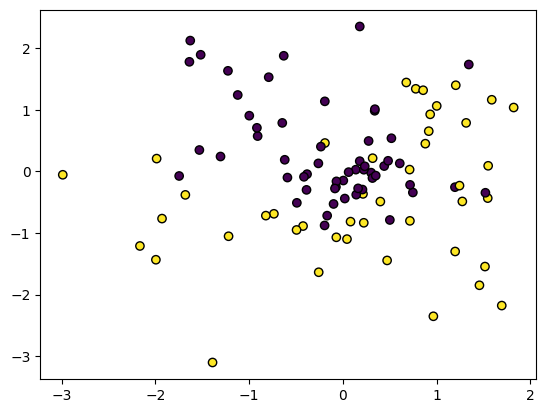

In [376]:
X_train, y_train, X_test, y_test = torch.load("data.pt")
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, edgecolors='k');

Here are definitions of two different feature maps, the "simple" one and the "quadratic" one.

They define feature spaces in $\mathbb{R}^3$ and $\mathbb{R}^6$, respectively.

In [377]:
def features_simple(X):
    return torch.concat((torch.ones_like(X[:,:1]), X), -1)

def features_quadratic(X):
    interactions = X.prod(-1, keepdim=True)
    return torch.concat((torch.ones_like(X[:,:1]),
                         X, X.pow(2), interactions), -1)

print("Dimension of Phi, `features_simple`:", features_simple(X_train).shape)
print("Dimension of Phi, `features_quadratic`:", features_quadratic(X_train).shape)

Dimension of Phi, `features_simple`: torch.Size([100, 3])
Dimension of Phi, `features_quadratic`: torch.Size([100, 6])


# TASK #1 (3 points): Define the model

The Bayesian logistic regression model we are working with has the form
$$\begin{align*}
\mathbf{w} &\sim \mathcal{N}(0, \sigma^2 \mathbf{I}) \\
\hat y_i &= \mathrm{Logistic}(\mathbf{w}^\top \phi(\mathbf{x}_i)) \\
y_i &\sim \mathrm{Bernoulli}(\hat y_i)
\end{align*}$$
where $i = 1,\dots, N$ and the Logistic function is defined
$$\begin{align*}
\mathrm{Logistic}(z) &= \frac{1}{1 + \exp\{-z\}}.
\end{align*}$$
It's implemented in pytorch as `torch.sigmoid`.

The first step is to define two functions, one to make predictions given a weight vector $\mathbf{w}$ and inputs $\Phi$, and one which computes the log joint probability

$$\log p(\mathbf{y}, \mathbf{w} | \mathbf{\Phi}, \sigma^2).$$

I've done the first one for you.

In [378]:
def predict_probs_MAP(Phi, w):
    """
    Given a "design matrix" Phi, and a point estimate w, compute p(y = 1 | Phi, w)

    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of
            observations and D is the number of features
    w     : (D,) vector of weights

    OUTPUT:
    y_hat : (N,) vector of probabilities p(y=1 | Phi, w)
    """
    return torch.sigmoid(Phi @ w)

In [379]:
def log_joint(Phi, y, w, sigma=10):
    """
    Compute the joint probability of the data and the latent variables.

    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w     : (D,) vector of weights
    sigma : scalar, standard deviation of Gaussian prior distribution p(w).
            Leave this set to sigma=10 for purposes of this exercise

    OUTPUT:
    log_joint : the log probability log p(y, w | Phi, sigma), a torch scalar

    """
    # Acquire index maximums
    N,D = Phi.shape

    # Taking log prob thus summing over every data-point x_n
    log_joint = 0

    # Calculate log prior of w
    log_joint += dist.MultivariateNormal(loc = torch.zeros(D), covariance_matrix = (sigma**2)*torch.eye(D)).log_prob(w).sum()

    # Now add the log likelihood for each data-point x_n
    prediction_y = predict_probs_MAP(Phi, w)
    log_joint += dist.Bernoulli(prediction_y).log_prob(y).sum()
    return log_joint

In [380]:
#Test case
X_train, y_train, X_test, y_test = torch.load("data.pt")
w = torch.ones(X_train.shape[1])
print(log_joint(X_train, y_train, w, sigma=10))

tensor(-103.5850)


In [381]:
# (GRADING)

In [382]:
# (GRADING)

# TASK 2 (5 points): Implement MAP estimation

Now you need to write a function which performs MAP estimation, i.e. penalized maximum likelihood estimation.

This function should find the value $\mathbf{w}_{MAP}$ that maximizes the log joint, i.e.

$$\mathbf{w}_{MAP} = \mathrm{argmax}_{\mathbf{w}}\log p(\mathbf{y}, \mathbf{w} | \mathbf{\Phi}, \sigma^2).$$

To do this, you should **use pytorch autograd tools**. This will involve defining an initial value of the weights, computing a scalar loss function, and calling `.backward()`, and then performing gradient-based optimization. Take a look at the demo notebooks from previous lectures for examples…!

* You **may feel free to use classes from `torch.optim`**. I would suggest the use of `torch.optim.SGD` or `torch.optim.Adagrad`.
* Regardless of how you do this, you will need to decide on a stopping criteria for your optimization routine.
* You will also need to decide on how to set the parameters (learning rate, momentum, anything else!) for your selected optimizer.

Also, **your code should work for ANY features!**. We will test this out on not just the "simple" and "quadratic" features above, but also on your own custom choice of features.

In [383]:
def find_MAP(Phi, y):
    """
    Find the MAP estimate of the log_joint method.

    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones


    OUTPUT:
    w      : (D,) vector of optimized weights
    losses : list of losses at each iteration of the optimization algorithm.
             Should be a list of scalars, which can be plotted afterward to
             diagnose convergence.
    """

    weights = torch.zeros(Phi.shape[1]).requires_grad_(True)
    # Track progress with losses list
    losses = []
    # I attempt SGD first
    # SGD returns graphs that are not as pretty as Adagrad optimisation
    opt = torch.optim.Adagrad((weights, ), lr=0.1)

    # Number of iterations
    iterations = 1000

    # Start optimisation
    for iteration in range(iterations):
        # zero the gradients
        opt.zero_grad()
        # forward pass
        log_joint_prob = -log_joint(Phi, y, weights)
        # backward pass
        log_joint_prob.backward()
        # save values to plot results
        losses.append(log_joint_prob.item())
        # Optimise once
        opt.step()

        # Stop optimising once difference in log_joint is below certain threshold
        if len(losses)>1:
          difference = losses[iteration-1] - losses[iteration]
          if difference < 0.001:
            break

    return weights.detach(), losses

### The following two cells call `find_MAP` to compute $\mathbf{w}$ for both choices of features.

Text(0, 0.5, 'Loss')

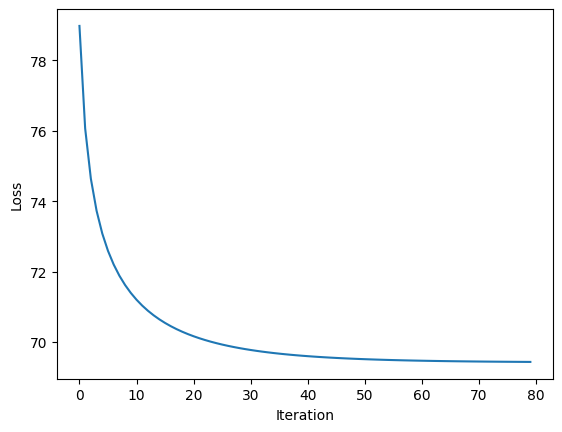

In [384]:
w_MAP_simple, losses = find_MAP(features_simple(X_train), y_train)
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

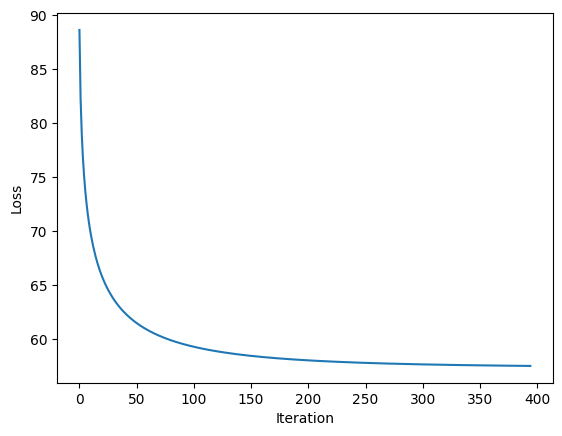

In [385]:
w_MAP_quad, losses = find_MAP(features_quadratic(X_train), y_train)
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")

In [386]:
# (GRADING)

In [387]:
# (GRADING)

## Visualization: The following code visualizes the classifier result

It plots the probability of being one class or the other using a color contour plot.

The decision boundary is a dashed black line.

In [388]:
def plot_boundary(X, y, pred):
    h = 0.2
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = pred(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=.8, levels=np.linspace(0, 1, 8))

    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')

    plt.contour(xx, yy, Z, levels=(0.5,), linestyles='dashed');

    # Plot the testing points
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

Simple features: training accuracy = 0.68, test accuracy = 0.68


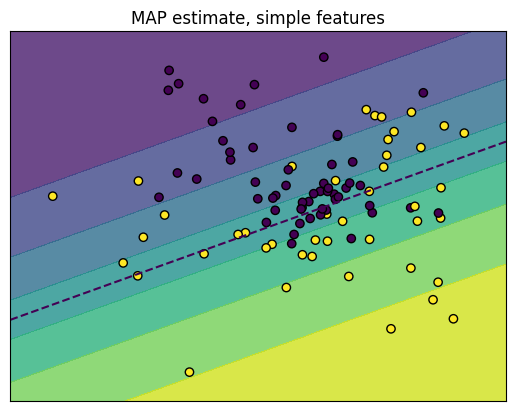

In [389]:
plot_boundary(X_train, y_train,
              lambda X: predict_probs_MAP(features_simple(X), w_MAP_simple))
plt.title("MAP estimate, simple features")
train_accuracy = (predict_probs_MAP(features_simple(X_train), w_MAP_simple).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_simple(X_test), w_MAP_simple).round() == y_test).float().mean()
print("Simple features: training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

Polynomial features: training accuracy = 0.86, test accuracy = 0.90


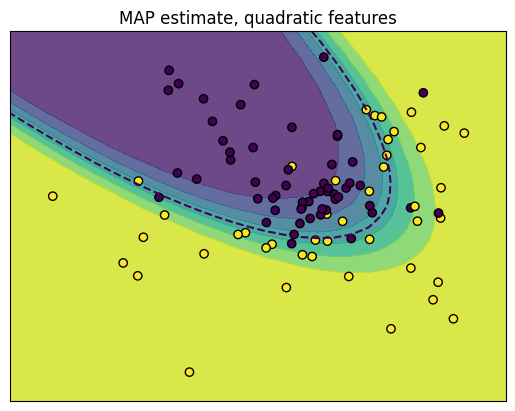

In [390]:
plot_boundary(X_train, y_train,
              lambda X: predict_probs_MAP(features_quadratic(X), w_MAP_quad))
plt.title("MAP estimate, quadratic features")
train_accuracy = (predict_probs_MAP(features_quadratic(X_train), w_MAP_quad).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_quadratic(X_test), w_MAP_quad).round() == y_test).float().mean()
print("Polynomial features: training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

# TASK #3 (5 points): Laplace approximation

In the next section, you will fit an approximate posterior over the weights by using the Laplace approximation around the mode $\mathbf{w}_{MAP}$ of the distribution you found above.

This requires completing two functions:

1. `compute_laplace_Cov` takes the data and the MAP estimate, and outputs a covariance matrix defined as the negative inverse Hessian of the log target density. (See the week 4 lecture slides for details on how to compute this!)
2. `predict_bayes` makes predictions on new data points, by approximating $\int p(y | x, w)p(w | \mathcal{D})dw$ when using a Gaussian approximation to $p(w | \mathcal{D})$. In the week 4 lecture slides we discussed three different ways of computing this — it is up to you to decide what method you would prefer, and implement it.

In [391]:
def compute_laplace_Cov(Phi, y, w_MAP, prior_std=10):
    """
    Compute the Laplace approximation of the posterior covariance
    in a logistic regression setting.

    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    sigma : scalar, standard deviation of Gaussian prior distribution p(w).
            Leave this set to sigma=10 for purposes of this exercise

    OUTPUT:
    Cov : (D, D) posterior covariance matrix estimate defined by the Laplace
          approximation
    """
    # Acquire index maximums
    N,D = Phi.shape

    # S_0 in the notes is sigma**2 * I in our case. Thus inverse of it is sigma**-2 * I
    inverse_s_0 = (prior_std**-2) * torch.eye(D)

    # Load prediction_y
    prediction_y = predict_probs_MAP(Phi, w_MAP)

    # Sum over N
    sum_over_n_matrix = torch.zeros_like(inverse_s_0)
    for n in range(N):
      sum_over_n_matrix += (prediction_y[n] * (1-prediction_y[n])) * (torch.reshape(Phi[n,:],(D,1)) @ torch.reshape(Phi[n,:],(1,D)))
    #sum_over_n_matrix = prediction_y * (1-prediction_y) * (torch.transpose(Phi,0,1) @ Phi)

    # Reminder, we need the inverse:
    uninversed_hessian = inverse_s_0 + sum_over_n_matrix
    hessian = torch.inverse(uninversed_hessian)

    return hessian

In [392]:
def predict_bayes(Phi, w_MAP, Cov):
    """
    Make predictions on new data points using an approximate posterior
    w ~ MultivariateNormal(w_MAP, Cov)

    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of
            observations and D is the number of features
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    Cov   : (D, D) approximate posterior covariance matrix

    OUTPUT:
    y_hat : (N,) vector of probabilities p(y=1 | Phi)
    """
    iterations = 10000
    # Use Monte Carlo to estimate to approximate the integral as shown on slide 21/72 of Notes
    # First come up with a way to sample from q(w) = Normal(mean=w*, standard deviation = hessian above)
    q_w = dist.MultivariateNormal(loc = w_MAP, covariance_matrix = Cov)

    # Now we can sample from q(w) via .sample()
    w_samples = q_w.sample(sample_shape = (iterations,))
    # Proceed by Monte Carlo approximating the integral
    y_hat = []
    for phi in Phi:
      y_hat.append((torch.sigmoid(w_samples @ phi).sum())/iterations)

    y_hat = torch.tensor(y_hat)
    return y_hat



### The following cells call your functions above to compute the Laplace approximation and visualize the posterior predictive distribution.

In [393]:
Cov_simple = compute_laplace_Cov(features_simple(X_train), y_train, w_MAP_simple)

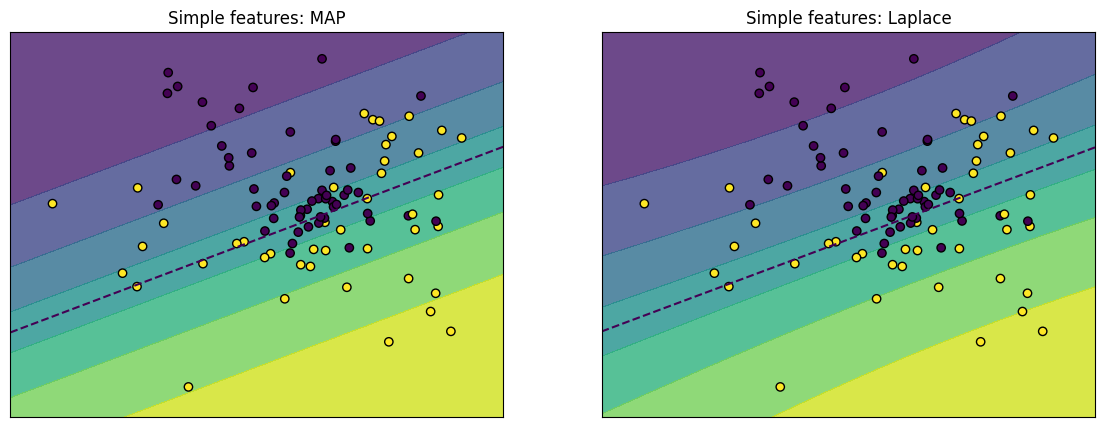

In [394]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("Simple features: MAP")
plot_boundary(X_train, y_train,
              lambda X: predict_probs_MAP(features_simple(X), w_MAP_simple))

plt.subplot(122)
plt.title("Simple features: Laplace")
plot_boundary(X_train, y_train,
              lambda X: predict_bayes(features_simple(X), w_MAP_simple, Cov_simple))

In [395]:
Cov_quad = compute_laplace_Cov(features_quadratic(X_train), y_train, w_MAP_quad)

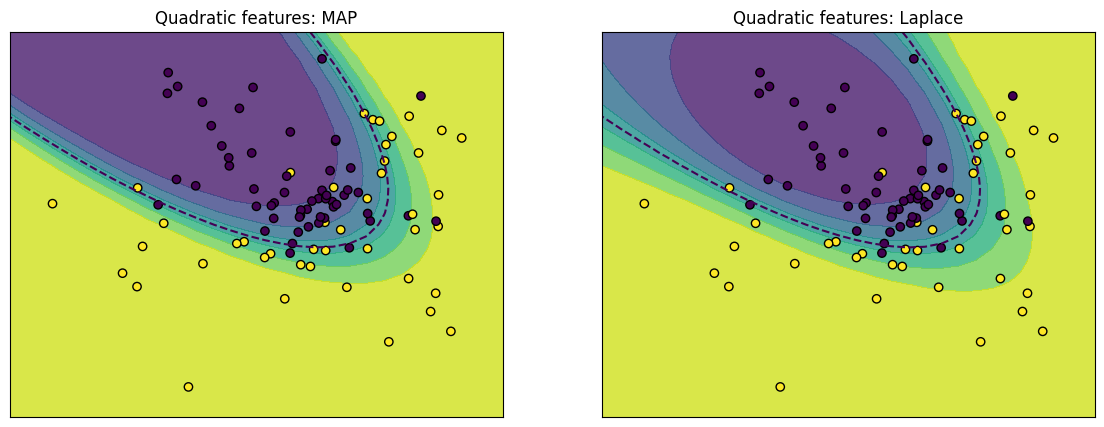

In [396]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("Quadratic features: MAP")
plot_boundary(X_train, y_train,
              lambda X: predict_probs_MAP(features_quadratic(X), w_MAP_quad))

plt.subplot(122)
plt.title("Quadratic features: Laplace")
plot_boundary(X_train, y_train,
              lambda X: predict_bayes(features_quadratic(X), w_MAP_quad, Cov_quad))

In [397]:
# (GRADING)

In [398]:
# (GRADING)

In [399]:
# (GRADING)

# TASK #4 (2 points): Model comparison

You can compute the marginal likelihood approximation defined by the Laplace approximation.

This estimate of the evidence can be used, even just looking at the training data, to help decide which of the two feature maps is more appropriate and better fits the data.

This can help guard against potential overfitting if using features that are "too complex".

In [400]:
def compute_laplace_log_evidence(Phi, y, w_MAP, Cov):
    """
    This computes the Laplace approximation to the marginal likelihood,
    as defined in the Week 5 lectures.

    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    Cov   : (D, D) approximate posterior covariance matrix

    OUTPUT:
    log_evidence : scalar value estimating `log p(y | Phi)`
    """
    # Acquire index maximums
    N,D = Phi.shape

    # Following slide 26/27 from the Notes, we approximate the modal evidence via the Laplace approximation we already have
    # First acquire log(Data = y|w_MAP) + log(prior(w_MAP)) which is the log_joint we have above
    log_nominator = log_joint(Phi, y, w_MAP)

    # Now acquire Occam Factor
    occam_factor = D*torch.log(2*torch.tensor(torch.pi))/2 - 0.5*torch.log(torch.det(torch.inverse(Cov)))

    result = log_nominator + occam_factor
    return result

In [401]:
print("Model evidence estimate (simple features):",
      compute_laplace_log_evidence(features_simple(X_train), y_train, w_MAP_simple, Cov_simple).item())

print("Model evidence estimate (polynomial features):",
      compute_laplace_log_evidence(features_quadratic(X_train), y_train, w_MAP_quad, Cov_quad).item())

Model evidence estimate (simple features): -70.98029327392578
Model evidence estimate (polynomial features): -57.96349334716797


In [402]:
# (GRADING)

# TASK #5 (2 points + 4 points): Define your own feature space

Your next task is to define your own, custom feature space! This can be practically any deterministic function from $\mathbb{R}^2$ to $\mathbb{R}^D$, and you even get to pick the dimensionality $D$.

In the following cells, you first define your feature space, and then we estimate the posterior using your code above. We report training accuracy, test accuracy, and model evidence, as well as plot the decision boundaries.

Feel free to get quite creative here! However, you will be asked to defend your choice of feature space in the free-answer section at the bottom.

**Make sure when you submit, you include whatever you consider the "best" possible choice!**

In [403]:
def features_student(X):
    """
    Compute your own, custom set of features!

    INPUT:
    X      : (N, 2) tensor of raw input data

    OUTPUT:
    Phi    : (N, D) tensor of transformed inputs
    """
    # Attempt radial basis functions
    # Column that is the distance to (0,0)
    X_column_1 = []
    for x in X:
      X_column_1.append(torch.norm(torch.tensor([0,0]) - torch.tensor([x[0],x[1]])))
    X_column_1 = torch.tensor(X_column_1)

    # Column that is the distance to (0,0)
    X_column_2 = []
    for x in X:
      X_column_2.append(torch.norm(torch.tensor([1,1]) - torch.tensor([x[0],x[1]])))
    X_column_2 = torch.tensor(X_column_2)

    # Bias column
    X_bias_column = torch.ones(X.shape[0])

    # Add the columns to the return variable
    X = torch.column_stack((X_bias_column, X, X_column_1, X_column_2))

    return X


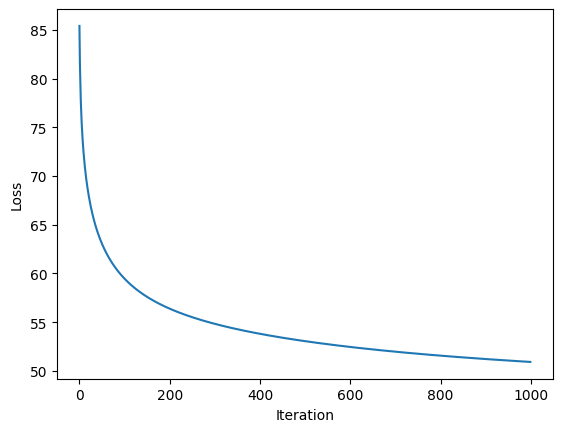

In [404]:
w_MAP_student, losses = find_MAP(features_student(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

In [405]:
train_accuracy = (predict_probs_MAP(features_student(X_train), w_MAP_student).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_student(X_test), w_MAP_student).round() == y_test).float().mean()
print("YOUR features! Training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))



YOUR features! Training accuracy = 0.86, test accuracy = 0.92


In [406]:
Cov_student = compute_laplace_Cov(features_student(X_train), y_train, w_MAP_student)

print("YOUR features! Model evidence estimate:",
      compute_laplace_log_evidence(features_student(X_train), y_train, w_MAP_student, Cov_student).item())

YOUR features! Model evidence estimate: -50.204036712646484


In [407]:
w_MAP_student

tensor([-0.0703, -0.5129, -2.8761,  3.6854, -2.4920])

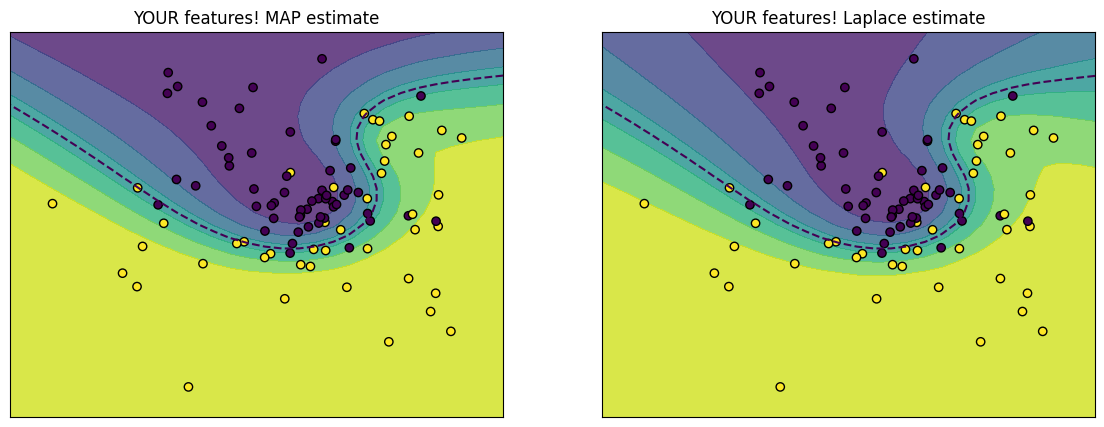

In [408]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("YOUR features! MAP estimate")
plot_boundary(X_train, y_train,
              lambda X: predict_probs_MAP(features_student(X), w_MAP_student))

plt.subplot(122)
plt.title("YOUR features! Laplace estimate")
plot_boundary(X_train, y_train,
              lambda X: predict_bayes(features_student(X), w_MAP_student, Cov_student))

# Please answer the following short questions:

1. *[Feature selection]* How did you choose your features? Name at least two ways of comparing whether one set of features is "better" than another. Would these methods generally yield the same "ranking" of different features? Why or why not?
2. *[Overfitting]* Is "overfitting" possible in this setting? Did you experience it? If so, how would you detect it? Does using the Laplace approximation "help" with overfitting, or does it not make a difference? Justify your answer.

### Question 1
I chose my feature map largely based on trial and error. I started by attempting to implement larger polynomial feature maps than the quadratic one, but that did not yield fruitful results (I think I was implementing it wrong), after failing with that idea for some time, I decided to test out the waters with radial basis functions. I first implemented what appears to be the most obvious cluster of purple points centered at around (0,0) and that yielded interesting result, and then I implemented a few other possible clusters for yellow points, but (1,1) is what ended up working best.
\
\
The two ways I compared feature maps (models in this case) is through modal evidence and training and testing error. Evidently, the lower the testing error is, the better our model is at making predictions. Thus if a certain feature map provides more testing accuracy than a different feature map, one can assume the feature map with most testing accuracy to be the best model. The problem with comparing models based off testing accuracy only is the possibility of over-fitting our model to satisfy test data only. This is where modal evidence offers another indication of model validity. As taught in lectures, modal evidence penalises overcomplicated models, thus helping us ensure our model is not overfitting. The higher the modal evidence, the less our model is overfitting.
\
\
Thus, model selection is a balance between testing accuracy and modal evidence. Finally, one can also quantify overfitting of our model through training error. If training error is low, the more chance our model overfit to training data.(Once again, this can also be compared to testing error, which would be high due to overfitting of training data, and modal evidence which would be low)
### Question 2
I do not think over-fitting is likely in a Bayesian setting. The fact that all models share modal evidence assures that overfitting is made considerably quite harder (as the penalty term, log modal evidence, becomes exponentially negatively larger as our model overfits the data). By following the model comparison indicators explained above, one can quantify over-fitting quite easily and tune the models according to their values.
\
\
I did not encounter overfitting during this exercise. As explained above, I would quantify overfitting using indicators such as testing error, training error and modal evidence. Reasons are explained in prior question so I summarise them here. If training error is really low, high chance our model overfit to train data, however, testing error would be high and modal evidence would be low, allowing us to quantify overfitting. If testing error is really low, high chance our model overfit to test data, however, training error would be high and modal evidence would be low, allowing us to quantify overfitting. In general, if modal evidence is low, the chance our model being overcomplicated is bad.
\
\
I would say the Laplace approximation does not help with overfitting. The Laplace approximation allows us to compute desired results, granted, accuracy from the ground-truth result is lost, but such ground-truth is not modified. Only the model being proposed determines overfitting to the data.
\
\
I should clarify, the Laplace approximation can help us acquire the modal evidence, which does evidently help against overfitting. If this is what is meant by the question, then yes, the Laplace approximation does help with overfitting.

#### Ignore the following cells. They are used by the grading system.

In [409]:
# (GRADING)

In [410]:
# (GRADING)